<a href="https://colab.research.google.com/github/aSafarpoor/KGCLG/blob/main/image_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

hi

In [ ]:
# !pip install tensorflow==2.6.0
# !pip install keras~=2.6.0

In [1]:
import json
from tqdm import tqdm
import random
from collections import Counter
import pandas as pd
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import requests
from io import BytesIO

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/KGCLG

Mounted at /content/drive/
/content/drive/My Drive/KGCLG


In [3]:
def pickle_reader(name):
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
        return b

In [4]:
meta = pickle_reader("meta128.pickle")

In [5]:
meta.head(5)

,asin,brand,imageURL,imageURLHighRes,category,text2vec
0,0176496920,"[TurningTechnologies,LLC]",https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,"[Industrial & Scientific, Industrial Electrica...",0 5.686413 1 1.676748 2 0.77843...
1,0781776848,[AnatomicalChartCompany],,,"[Industrial & Scientific, Science Education]",0 -3.541129 1 0.624808 2 2.82086...
2,0781786606,[AnatomicalChartCompany],,,"[Industrial & Scientific, Science Education, C...",0 -1.792426 1 1.343096 2 5.33961...
3,0840026080,[ResponsiveInnovations],https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,"[Industrial & Scientific, Industrial Electrica...",0 2.297853 1 3.702615 2 5.74182...
4,1587790319,[AnatomicalChartCompany],,,"[Industrial & Scientific, Science Education, C...",0 0.505276 1 -0.173542 2 2.04781...


In [9]:
img = [i for i in list(meta.imageURL) if len(i)]
imgh = [i for i in list(meta.imageURLHighRes) if len(i)]
len(img),len(imgh)

(59476, 59476)

In [10]:
len(meta)

147329

# collect data

In [11]:
li = img
hi = imgh

In [12]:
li[0],hi[0]

('https://images-na.ssl-images-amazon.com/images/I/51ptWXqrj3L._SX38_SY50_CR,0,0,38,50_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51ptWXqrj3L.jpg')

In [13]:
def im_reader(link , draw=False , pil=False):
    response = requests.get(link)
    img = Image.open(BytesIO(response.content))
    if pil:
        return img
    im2arr = np.array(img)
    if draw:
        imgplot = plt.imshow(im2arr)
        plt.show()
    return im2arr

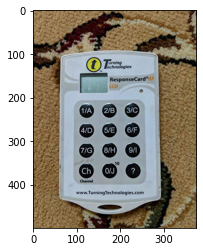

In [15]:
img = im_reader(hi[0],True)


# embedding phase

In [ ]:
# import cv2
# dim = (100,100,3)
# resized_image = cv2.resize(img, (224, 224)) 
# resized_image.reshape(224,224,3)
# img.shape ,resized_image.shape

In [ ]:
# imgplot = plt.imshow(img)
# plt.show()

In [16]:
from torchvision import models
import torch
# dir(models)

In [17]:
alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [18]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
from torchvision import transforms

transform = transforms.Compose([            #[1]
    transforms.Resize(256),                    #[2]
    transforms.CenterCrop(224),                #[3]
    transforms.ToTensor(),                     #[4]
    transforms.Normalize(                      #[5]
    mean=[0.485, 0.456, 0.406],                #[6]
    std=[0.229, 0.224, 0.225]                  #[7]
)])


In [24]:
def batch_t_creator(url):
    img = im_reader(url,True,True)
    img_t = transform(img)
    # print(img_t)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t

In [25]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# out = alexnet(batch_t)
# print(out.shape)

In [27]:
# print(out[0].shape)

In [ ]:
out_list = []
c = 0
for i in tqdm(range(len(hi))):
    a = hi[i]
    # print()
    
    c+=1
    batch_t = batch_t_creator(url=a)
    out = alexnet(batch_t)
    out_list.append(out)

  0%|          | 152/59476 [00:37<11:06:31,  1.48it/s]